# Load the dataset

In [1]:
import locale
import gdown
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

url = 'https://drive.google.com/uc?id=1lsO7hW2npiQXbozGGmKAUb8NrXsVsZBd'
gdown.download(url, quiet=False)
! unzip DIV2K.zip

Downloading...
From: https://drive.google.com/uc?id=1lsO7hW2npiQXbozGGmKAUb8NrXsVsZBd
To: /content/DIV2K.zip
100%|██████████| 5.75G/5.75G [01:17<00:00, 74.6MB/s]


Archive:  DIV2K.zip
   creating: DIV2K/
  inflating: __MACOSX/._DIV2K        
   creating: DIV2K/valid/
   creating: DIV2K/DIV2K_train_HR/
  inflating: DIV2K/.DS_Store         
  inflating: __MACOSX/DIV2K/._.DS_Store  
   creating: DIV2K/train/
   creating: DIV2K/DIV2K_valid_HR/
  inflating: DIV2K/valid/.DS_Store   
  inflating: __MACOSX/DIV2K/valid/._.DS_Store  
   creating: DIV2K/valid/hologram/
   creating: DIV2K/DIV2K_train_HR/DIV2K_train_HR/
  inflating: DIV2K/DIV2K_train_HR/.DS_Store  
  inflating: __MACOSX/DIV2K/DIV2K_train_HR/._.DS_Store  
  inflating: DIV2K/train/.DS_Store   
  inflating: __MACOSX/DIV2K/train/._.DS_Store  
   creating: DIV2K/train/hologram/
  inflating: DIV2K/DIV2K_valid_HR/.DS_Store  
  inflating: __MACOSX/DIV2K/DIV2K_valid_HR/._.DS_Store  
   creating: DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/
  inflating: DIV2K/valid/hologram/0878.png  
  inflating: DIV2K/valid/hologram/0850.png  
  inflating: DIV2K/valid/hologram/0844.png  
  inflating: DIV2K/valid/hologram/089

In [7]:
import os
os.chdir("/content/DIV2K/DIV2K_train_HR/DIV2K_train_HR/")
print(os.getcwd())

/content/DIV2K/DIV2K_train_HR/DIV2K_train_HR


# Install the open library Odak

In [3]:
! pip3 install odak

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odak: filename=odak-0.2.3-py3-none-any.whl size=136341 sha256=d0ad4b46a8839b8f8c5a5b7a01ffd9d905e1ccccadbbc8e94f384a62a871c617
  Stored in directory: /root/.cache/pip/wheels/4e/f5/e6/810fe1b4931a4dd0eb12d9d6dec9642745ed9fc48f36f09b90
Successfully built odak


# Load library functions

In [4]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import os
from odak.learn.wave import wavenumber,generate_complex_field,calculate_amplitude,propagate_beam,linear_grating,calculate_phase,stochastic_gradient_descent, set_amplitude
from odak.learn.tools import zero_pad,crop_center,save_image,psnr
from odak import np
from tqdm import tqdm
from odak.tools import load_dictionary
import argparse
import glob
import torch
from odak.learn.tools import load_image
from PIL import Image
import matplotlib.pyplot as plt
import time

# Part 1: Implementation

## 1. Set the constants.

In [5]:
# Constants
wavelength = 0.000000532
dx = 0.00000374
resolution = [1080, 1920]
distance = 0.55
iteration_number =100
learning_rate = 0.02
cuda = True
propagation_type = 'Bandlimited Angular Spectrum'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 2. Load an arbitray image from the loaded dataset for test.

In [8]:
img_numpy = np.array(Image.open('./0006.png').resize((1920,1080)))
target=torch.from_numpy(np.mean(img_numpy,axis=2, dtype=np.float32))/255.0

## 3. Save the hologram and its corresponding reconstruction image.

In [ ]:
# The code of how to use this stochastic_gradient_descent and how to save the image and phase-only hologram correctly is from the Odak tutorial webstie:
# http://kaanaksit.com/odak/notes/holographic_light_transport/

# Optimize hologram
hologram, reconstructed = stochastic_gradient_descent(
    target,
    wavelength,
    distance,
    dx,
    resolution,
    propagation_type,
    iteration_number,
    learning_rate=learning_rate,
    cuda=True
)

# Save reconstructed image
reconstructed_intensity = calculate_amplitude(reconstructed)**2
save_image('reconstructed_image_ori.png',reconstructed_intensity,cmin=0.,cmax=1.)

# Normalize and save phase hologram
slm_range = 2*3.14
dynamic_range = 255

phase_hologram = calculate_phase(hologram)
phase_only_hologram = (phase_hologram%slm_range)/(slm_range)*dynamic_range
save_image('phase_only_hologram_ori.png',phase_only_hologram)

True

## 4. Generate the large kernel for learning.

In [ ]:
def evaluate(image,target,criterion,w=[1.,]):
    loss   = w[0]*criterion[0](image,target)
    return loss

# This code section of generate_large_kernel is from an open library Odak: https://github.com/kaanaksit/odak
# The only modification is to enlarge the large kernel to two channel: one for aplitude another one for phase, instead of the complex value large kernel.
def generate_large_kernel(field, k, distance, dx, wavelength, zero_padding, myDevice):
    """
    A definition to calculate bandlimited angular spectrum based beam propagation. For more
    `Matsushima, Kyoji, and Tomoyoshi Shimobaba. "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." Optics express 17.22 (2009): 19662-19673`.

    Parameters
    ----------
    field            : torch.complex
                       A complex field.
                       The expected size is [m x n].
    k                : odak.wave.wavenumber
                       Wave number of a wave, see odak.wave.wavenumber for more.
    distance         : float
                       Propagation distance.
    dx               : float
                       Size of one single pixel in the field grid (in meters).
    wavelength       : float
                       Wavelength of the electric field.
    zero_padding     : bool
                       Zero pad in Fourier domain.


    Returns
    -------
    result           : torch.complex
                       Final complex field [m x n].
    """
    distance = torch.tensor([distance], device = myDevice)
    nv, nu = field[-1], field[-2]
    y, x = (dx * float(nv), dx * float(nu))
    fy = torch.linspace(-1 / (2 * dx) + 0.5 / (2 * y), 1 / (2 * dx) - 0.5 / (2 * y), nv, dtype = torch.float32, device = myDevice)
    fx = torch.linspace(-1 / (2 * dx) + 0.5 / (2 * x), 1 / (2 * dx) - 0.5 / (2 * x), nu, dtype = torch.float32, device = myDevice)
    FY, FX = torch.meshgrid(fx, fy, indexing='ij')
    HH = 2 * np.pi * torch.sqrt(1 / wavelength ** 2 - (FX ** 2 + FY ** 2))
    H_exp = HH.to(myDevice)
    H_exp = torch.mul(H_exp, distance)
    fy_max = 1 / torch.sqrt((2 * distance * (1 / y))**2 + 1) / wavelength
    fx_max = 1 / torch.sqrt((2 * distance * (1 / x))**2 + 1) / wavelength
    H_filter = ((torch.abs(FX) < fx_max) & (torch.abs(FY) < fy_max)).clone().detach()
    H = generate_complex_field(H_filter,H_exp)
    H_amplitude = calculate_amplitude(H)
    H_phase = calculate_phase(H)
    H =  torch.stack((H_amplitude, H_phase))

    return H

## 5. Prepare the intermedia values for training.

In [ ]:
def prepare():
    torch.cuda.empty_cache()
    torch.manual_seed(0)
    cuda          = 1
    resolution_padded    = [2160,3840]
    K_phase = 1
    K_amplitude= 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if cuda:
       torch.cuda.empty_cache()
    torch.random.seed()

    kernel_width_amplitude        = torch.rand(
                               1,
                               1,
                               K_amplitude,
                               resolution_padded[1],
                              ).detach().to(device).requires_grad_()
    kernel_height_amplitude        = torch.rand(
                               1,
                               1,
                               resolution_padded[0],
                               K_amplitude,
                              ).detach().to(device).requires_grad_()

    kernel_width_phase        = torch.rand(
                               1,
                               1,
                               K_phase,
                               resolution_padded[1],
                              ).detach().to(device).requires_grad_()
    kernel_height_phase        = torch.rand(
                               1,
                               1,
                               resolution_padded[0],
                               K_phase,
                              ).detach().to(device).requires_grad_()

    criterion     = [
                     nn.MSELoss().to(device),
                    ]

    large_kernel = generate_large_kernel(resolution_padded, wavenumber(wavelength), distance, dx, wavelength, False, device).to(device)

    return large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase, kernel_height_phase,criterion,K_amplitude,K_phase,resolution_padded

In [ ]:
large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase, kernel_height_phase,criterion,K_amplitude,K_phase,resolution_padded = prepare()


## 6.Training the vector kernels using the large kernel generated above.

In [ ]:
def find_small_kernels(large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase,kernel_height_phase, criterion, device, K_amplitude,K_phase):
    loss_weights     = [1.0]
    learning_rate    = 0.05
    n_iterations     = 100
    optimizer        = optim.Adam([{'params': [kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase]}],lr=learning_rate)

    height = resolution_padded[0]
    width = resolution_padded[1]
    t     = range(n_iterations)
    large_amplitude = large_kernel[0,:,:]
    large_phase = large_kernel[1,:,:]/(2*torch.pi)
    for n in t:
        t0         = range(K_amplitude)
        t1 = range(K_phase)
        approximate_kernel = torch.zeros((2,resolution_padded[0],resolution_padded[1]), dtype=torch.float).to(device)

        for i in t0:
            h_width_amplitude = kernel_width_amplitude[0,0,i,:]
            h_width_amplitude = h_width_amplitude.unsqueeze(0)
            h_height_amplitude = kernel_height_amplitude[0,0,:,i]
            h_height_amplitude = h_height_amplitude.unsqueeze(-1)
            approximate_kernel[0,:,:] = approximate_kernel[0,:,:] + h_height_amplitude*h_width_amplitude

        for i in t1:
            h_width_phase = kernel_width_phase[0,0,i,:]
            h_width_phase = h_width_phase.unsqueeze(0)
            h_height_phase = kernel_height_phase[0,0,:,i]
            h_height_phase = h_height_phase.unsqueeze(-1)
            approximate_kernel[1,:,:] = approximate_kernel[1,:,:] + h_height_phase*h_width_phase


        loss               = evaluate(approximate_kernel[0,:,:],large_amplitude,criterion)+evaluate(approximate_kernel[1,:,:],large_phase,criterion)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        print("Iteration:{}, Loss:{:.4f}".format(n,loss.item()))

    torch.cuda.empty_cache()
    return kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase

In [ ]:
kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase = find_small_kernels(large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase,kernel_height_phase, criterion, device, K_amplitude,K_phase)

Iteration:0, Loss:0.2317
Iteration:1, Loss:0.1840
Iteration:2, Loss:0.1490
Iteration:3, Loss:0.1238
Iteration:4, Loss:0.1059
Iteration:5, Loss:0.0935
Iteration:6, Loss:0.0849
Iteration:7, Loss:0.0790
Iteration:8, Loss:0.0749
Iteration:9, Loss:0.0721
Iteration:10, Loss:0.0701
Iteration:11, Loss:0.0686
Iteration:12, Loss:0.0674
Iteration:13, Loss:0.0664
Iteration:14, Loss:0.0656
Iteration:15, Loss:0.0647
Iteration:16, Loss:0.0638
Iteration:17, Loss:0.0630
Iteration:18, Loss:0.0620
Iteration:19, Loss:0.0611
Iteration:20, Loss:0.0602
Iteration:21, Loss:0.0592
Iteration:22, Loss:0.0582
Iteration:23, Loss:0.0573
Iteration:24, Loss:0.0564
Iteration:25, Loss:0.0556
Iteration:26, Loss:0.0548
Iteration:27, Loss:0.0541
Iteration:28, Loss:0.0533
Iteration:29, Loss:0.0526
Iteration:30, Loss:0.0520
Iteration:31, Loss:0.0514
Iteration:32, Loss:0.0509
Iteration:33, Loss:0.0504
Iteration:34, Loss:0.0499
Iteration:35, Loss:0.0496
Iteration:36, Loss:0.0493
Iteration:37, Loss:0.0491
Iteration:38, Loss:0.0



## 7. Reconstruct the kernel and propagate for a single propagation.

In [ ]:
def reconstruct_kernel_and_propagate(field,kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, K_amplitude,K_phase):
    reconstructed_kernel_amplitude = torch.zeros(resolution_padded, dtype=torch.float).to(device)
    reconstructed_kernel_phase = torch.zeros(resolution_padded, dtype=torch.float).to(device)
    height = resolution_padded[0]//2
    width = resolution_padded[1]//2

    for i in range(K_amplitude):
      h_width_amplitude = kernel_width_amplitude[0,0,i,:]
      h_width_amplitude = h_width_amplitude.unsqueeze(0)

      h_height_amplitude = kernel_height_amplitude[0,0,:,i]
      h_height_amplitude = h_height_amplitude.unsqueeze(-1)

    for i in range(K_phase):
      h_width_phase = kernel_width_phase[0,0,i,:]
      h_width_phase = h_width_phase.unsqueeze(0)

      h_height_phase = kernel_height_phase[0,0,:,i]
      h_height_phase = h_height_phase.unsqueeze(-1)



    reconstructed_kernel = generate_complex_field(h_height_amplitude*h_width_amplitude, h_height_phase*h_width_phase*(2*torch.pi))

    U1 = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field)))
    U2 = reconstructed_kernel*U1

    result = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(U2)))

    return result



from tqdm import tqdm

# Reference: https://github.com/kaanaksit/odak/blob/master/odak/learn/wave/classical.py
def sgd(field,wavelength,distance,dx,resolution,n_iteration=100,loss_function=None,cuda=False,learning_rate=0.01):
    torch.cuda.empty_cache()
    torch.manual_seed(0)
    device    = torch.device("cuda" if cuda else "cpu")
    field     = field.to(device)
    phase     = torch.rand(resolution[0],resolution[1]).detach().to(device).requires_grad_()
    amplitude = torch.ones(resolution[0],resolution[1],requires_grad=False).to(device)

    optimizer = torch.optim.Adam([{'params': [phase]}],lr=learning_rate)
    if type(loss_function) == type(None):
        loss_function = torch.nn.MSELoss().to(device)
    t = tqdm(range(n_iteration),leave=False)
    for i in t:
        optimizer.zero_grad()
        hologram                 = amplitude*torch.cos(phase)+1j*amplitude*torch.sin(phase)
        reconstruction    = crop_center(reconstruct_kernel_and_propagate(zero_pad(hologram), kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, K_amplitude,K_phase))
        reconstruction_intensity = torch.abs(reconstruction)**2
        loss                     = loss_function(reconstruction_intensity,field)
        description              = "Iteration: {} loss:{:.4f}".format(i,loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        t.set_description(description)
    print(description)
    torch.no_grad()
    hologram              = amplitude*torch.cos(phase)+1j*amplitude*torch.sin(phase)
    reconstruction = crop_center(reconstruct_kernel_and_propagate(zero_pad(hologram), kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, K_amplitude,K_phase))

    return hologram.detach(), reconstruction.detach()

## 8. Generate the new phase-only hologram and its reconstruction for test and the comparasion between the large kernel and the small kernels.

### 8.1 Generate the phase-only hologram and its reconstruction image.

In [ ]:
img_numpy = np.array(Image.open('./0013.png').resize((1920,1080)))
target=torch.from_numpy(np.mean(img_numpy,axis=2, dtype=np.float32))/255.0
# Optimize hologram
hologram_test, reconstructed_test = sgd(
    target,
    wavelength,
    distance,
    dx,
    [1080,1920],
    100,
    learning_rate=learning_rate,
    cuda=True
)

Iteration: 99 loss:0.0023


### 8.2 Show the reconstructed image

<function matplotlib.pyplot.show(close=None, block=None)>

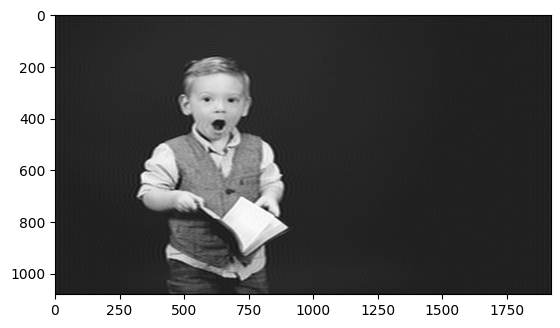

In [ ]:
reconstructed_intensity_test = calculate_amplitude(reconstructed_test)**2
plt.imshow(reconstructed_intensity_test.detach().to('cpu'), cmap='gray', vmin=0.,vmax=1.)
plt.show

### 8.3 Show the comparasion between the original image and the reconstructed image.

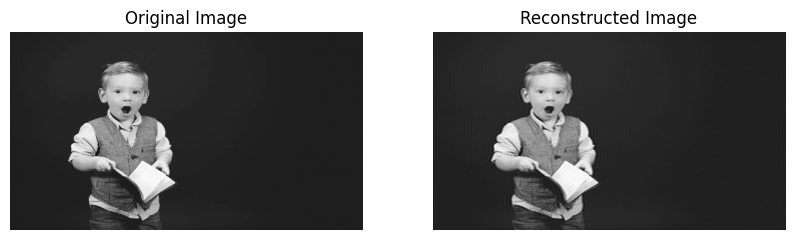

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(target, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(reconstructed_intensity_test.detach().to('cpu'), cmap='gray', vmin=0.,vmax=1.)
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')

plt.show()



---



---



# Part2: Experiment : In order to process the experiment more conveniently, the code in th implementation is integrated together in this experiment part.

## Part02 - Draw the loss changes graph.

## 1. The code to implement the large kernel method has been integrated together in this block.

In [9]:
# The code in this block is from the open library Odak: https://github.com/kaanaksit/odak/blob/master/odak/learn/wave/classical.py
# The only modification of the code here is to output the loss for drawing the loss graph.
def evaluate(image,target,criterion,w=[1.,]):
    loss   = w[0]*criterion[0](image,target)
    return loss

def band_limited_angular_spectrum(field, k, distance, dx, wavelength, zero_padding=False):
    """
    A definition to calculate bandlimited angular spectrum based beam propagation. For more
    `Matsushima, Kyoji, and Tomoyoshi Shimobaba. "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." Optics express 17.22 (2009): 19662-19673`.

    Parameters
    ----------
    field            : torch.complex
                       Complex field (MxN).
    k                : odak.wave.wavenumber
                       Wave number of a wave, see odak.wave.wavenumber for more.
    distance         : float
                       Propagation distance.
    dx               : float
                       Size of one single pixel in the field grid (in meters).
    wavelength       : float
                       Wavelength of the electric field.
    zero_padding     : bool
                       Zero pad in Fourier domain.


    Returns
    -------
    result           : torch.complex
                       Final complex field (MxN).
    """
    distance = torch.tensor([distance]).to(field.device)
    nv, nu = field.shape[-1], field.shape[-2]
    y, x = (dx * float(nv), dx * float(nu))
    fy = torch.linspace(-1 / (2 * dx) + 0.5 / (2 * y), 1 / (2 * dx) - 0.5 / (2 * y), nv, dtype=torch.float32).to(field.device)
    fx = torch.linspace(-1 / (2 * dx) + 0.5 / (2 * x), 1 / (2 * dx) - 0.5 / (2 * x), nu, dtype=torch.float32).to(field.device)
    FY, FX = torch.meshgrid(fx, fy, indexing='ij')
    HH = 2 * np.pi * torch.sqrt(1 / wavelength ** 2 - (FX ** 2 + FY ** 2))
    H_exp = HH.to(field.device)
    H_exp = torch.mul(H_exp, distance)
    fy_max = 1 / torch.sqrt((2 * distance * (1 / y))**2 + 1) / wavelength
    fx_max = 1 / torch.sqrt((2 * distance * (1 / x))**2 + 1) / wavelength
    H_filter = ((torch.abs(FX) < fx_max) & (torch.abs(FY) < fy_max)).clone().detach()
    H = generate_complex_field(H_filter,H_exp)
    U1 = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field)))
    if zero_padding == False:
       U2 = H * U1
    elif zero_padding == True:
       U2 = zero_pad(H) * zero_pad(U1)
    result = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(U2)))
    return result

def propagate_beam(
                   field,
                   k,
                   distance,
                   dx,
                   wavelength,
                   kernel = None,
                   zero_padding = [False, False, False]
                  ):

    result = band_limited_angular_spectrum(field, k, distance, dx, wavelength,zero_padding[1])
    if zero_padding[2]:
        result = crop_center(result)
    return result

def stochastic_gradient_descent_losses(field, wavelength, distance, dx, resolution, propogation_type, n_iteration=100, loss_function=None, cuda=False, learning_rate=0.1):
    """
    Definition to generate phase and reconstruction from target image via stochastic gradient descent.

    Parameters
    ----------
    field                   : torch.Tensor
                              Target field amplitude.
    wavelength              : double
                              Set if the converted array requires gradient.
    distance                : double
                              Hologaram plane distance wrt SLM plane
    dx                      : float
                              SLM pixel pitch
    resolution              : array
                              SLM resolution
    propogation_type        : str
                              Type of the propagation (see odak.learn.wave.propagate_beam())
    n_iteration:            : int
                              Max iteratation
    loss_function:          : function
                              If none it is set to be l2 loss
    cuda                    : boolean
                              GPU enabled
    learning_rate           : float
                              Learning rate.

    Returns
    -------
    hologram                : torch.Tensor
                              Phase only hologram as torch array

    reconstruction_intensity: torch.Tensor
                              Reconstruction as torch array

    """
    torch.cuda.empty_cache()
    torch.manual_seed(0)
    device = torch.device("cuda" if cuda else "cpu")
    field = field.to(device)
    phase = torch.rand(resolution[0], resolution[1]).detach().to(
        device).requires_grad_()
    amplitude = torch.ones(
        resolution[0], resolution[1], requires_grad=False).to(device)
    k = wavenumber(wavelength)
    optimizer = torch.optim.Adam([{'params': [phase]}], lr=learning_rate)
    if type(loss_function) == type(None):
        loss_function = torch.nn.MSELoss().to(device)
    t = tqdm(range(n_iteration), leave = False, dynamic_ncols = True)
    losses = []
    for i in t:
        optimizer.zero_grad()
        hologram = generate_complex_field(amplitude, phase)
        hologram_padded = zero_pad(hologram)
        reconstruction_padded = propagate_beam(
            hologram_padded, k, distance, dx, wavelength)
        reconstruction = crop_center(reconstruction_padded)
        reconstruction_intensity = calculate_amplitude(reconstruction)**2
        loss = loss_function(reconstruction_intensity, field)
        description = "Iteration: {} loss:{:.4f}".format(i, loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        t.set_description(description)
        losses.append(loss.item())
    print(description)
    torch.no_grad()
    hologram = generate_complex_field(amplitude, phase)
    hologram_padded = zero_pad(hologram)
    reconstruction_padded = propagate_beam(
        hologram_padded, k, distance, dx, wavelength)
    reconstruction = crop_center(reconstruction_padded)
    hologram = crop_center(hologram_padded)
    return hologram.detach(), reconstruction.detach(), losses



## 2. The code to implement the vector kernel method is integrated together in this block.

In [10]:
# The code in this block refer to the open library Odak for the framework and some implementation detail:
# Odak: https://github.com/kaanaksit/odak/blob/master/odak/learn/wave/classical.py
def generate_large_kernel(field, k, distance, dx, wavelength, zero_padding, myDevice):
    """
    A definition to calculate bandlimited angular spectrum based beam propagation. For more
    `Matsushima, Kyoji, and Tomoyoshi Shimobaba. "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." Optics express 17.22 (2009): 19662-19673`.

    Parameters
    ----------
    field            : torch.complex
                       A complex field.
                       The expected size is [m x n].
    k                : odak.wave.wavenumber
                       Wave number of a wave, see odak.wave.wavenumber for more.
    distance         : float
                       Propagation distance.
    dx               : float
                       Size of one single pixel in the field grid (in meters).
    wavelength       : float
                       Wavelength of the electric field.
    zero_padding     : bool
                       Zero pad in Fourier domain.


    Returns
    -------
    result           : torch.complex
                       Final complex field [m x n].
    """
    distance = torch.tensor([distance], device = myDevice)
    nv, nu = field[-1], field[-2]
    y, x = (dx * float(nv), dx * float(nu))
    fy = torch.linspace(-1 / (2 * dx) + 0.5 / (2 * y), 1 / (2 * dx) - 0.5 / (2 * y), nv, dtype = torch.float32, device = myDevice)
    fx = torch.linspace(-1 / (2 * dx) + 0.5 / (2 * x), 1 / (2 * dx) - 0.5 / (2 * x), nu, dtype = torch.float32, device = myDevice)
    FY, FX = torch.meshgrid(fx, fy, indexing='ij')
    HH = 2 * np.pi * torch.sqrt(1 / wavelength ** 2 - (FX ** 2 + FY ** 2))
    H_exp = HH.to(myDevice)
    H_exp = torch.mul(H_exp, distance)
    fy_max = 1 / torch.sqrt((2 * distance * (1 / y))**2 + 1) / wavelength
    fx_max = 1 / torch.sqrt((2 * distance * (1 / x))**2 + 1) / wavelength
    H_filter = ((torch.abs(FX) < fx_max) & (torch.abs(FY) < fy_max)).clone().detach()
    H = generate_complex_field(H_filter,H_exp)
    H_amplitude = calculate_amplitude(H)
    H_phase = calculate_phase(H)
    H =  torch.stack((H_amplitude, H_phase))

    return H


def prepare():
    torch.cuda.empty_cache()
    torch.manual_seed(0)
    cuda          = 1
    resolution_padded    = [2160,3840]
    K_phase = 1
    K_amplitude= 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if cuda:
       torch.cuda.empty_cache()
    torch.random.seed()

    kernel_width_amplitude        = torch.rand(
                               1,
                               1,
                               K_amplitude,
                               resolution_padded[1],
                              ).detach().to(device).requires_grad_()
    kernel_height_amplitude        = torch.rand(
                               1,
                               1,
                               resolution_padded[0],
                               K_amplitude,
                              ).detach().to(device).requires_grad_()

    kernel_width_phase        = torch.rand(
                               1,
                               1,
                               K_phase,
                               resolution_padded[1],
                              ).detach().to(device).requires_grad_()
    kernel_height_phase        = torch.rand(
                               1,
                               1,
                               resolution_padded[0],
                               K_phase,
                              ).detach().to(device).requires_grad_()

    criterion     = [
                     nn.MSELoss().to(device),
                    ]

    large_kernel = generate_large_kernel(resolution_padded, wavenumber(wavelength), distance, dx, wavelength, False, device).to(device)

    return large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase, kernel_height_phase,criterion,K_amplitude,K_phase,resolution_padded

from tqdm import tqdm

def find_small_kernels(large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase,kernel_height_phase, criterion, device, K_amplitude,K_phase,resolution_padded):
    loss_weights     = [1.0]
    learning_rate    = 0.05
    n_iterations     = 150
    optimizer        = optim.Adam([{'params': [kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase]}],lr=learning_rate)

    height = resolution_padded[0]
    width = resolution_padded[1]
    t     = tqdm(range(n_iterations))
    large_amplitude = large_kernel[0,:,:]
    large_phase = large_kernel[1,:,:]/(2*torch.pi)
    for n in t:
        t0         = range(K_amplitude)
        t1 = range(K_phase)
        approximate_kernel = torch.zeros((2,resolution_padded[0],resolution_padded[1]), dtype=torch.float).to(device)

        for i in t0:
            h_width_amplitude = kernel_width_amplitude[0,0,i,:]
            h_width_amplitude = h_width_amplitude.unsqueeze(0)
            h_height_amplitude = kernel_height_amplitude[0,0,:,i]
            h_height_amplitude = h_height_amplitude.unsqueeze(-1)
            # Implemente the vector multiplication to reconstruct the large kernel.
            approximate_kernel[0,:,:] = approximate_kernel[0,:,:] + h_height_amplitude*h_width_amplitude

        for i in t1:
            h_width_phase = kernel_width_phase[0,0,i,:]
            h_width_phase = h_width_phase.unsqueeze(0)
            h_height_phase = kernel_height_phase[0,0,:,i]
            h_height_phase = h_height_phase.unsqueeze(-1)
            # Implemente the vector multiplication to reconstruct the large kernel.
            approximate_kernel[1,:,:] = approximate_kernel[1,:,:] + h_height_phase*h_width_phase


        loss               = evaluate(approximate_kernel[0,:,:],large_amplitude,criterion)+evaluate(approximate_kernel[1,:,:],large_phase,criterion)
        description              = "Training vector kernels: Iteration:{}, Loss:{:.4f}".format(n,loss.item())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        t.set_description(description)

    torch.cuda.empty_cache()
    return kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase


def reconstruct_kernel_and_propagate(field,kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, K_amplitude,K_phase,resolution_padded):
    reconstructed_kernel_amplitude = torch.zeros(resolution_padded, dtype=torch.float).to(device)
    reconstructed_kernel_phase = torch.zeros(resolution_padded, dtype=torch.float).to(device)
    height = resolution_padded[0]//2
    width = resolution_padded[1]//2

    for i in range(K_amplitude):
      h_width_amplitude = kernel_width_amplitude[0,0,i,:]
      h_width_amplitude = h_width_amplitude.unsqueeze(0)

      h_height_amplitude = kernel_height_amplitude[0,0,:,i]
      h_height_amplitude = h_height_amplitude.unsqueeze(-1)

    for i in range(K_phase):
      h_width_phase = kernel_width_phase[0,0,i,:]
      h_width_phase = h_width_phase.unsqueeze(0)

      h_height_phase = kernel_height_phase[0,0,:,i]
      h_height_phase = h_height_phase.unsqueeze(-1)

    reconstructed_kernel = generate_complex_field(h_height_amplitude*h_width_amplitude, h_height_phase*h_width_phase*(2*torch.pi))

    U1 = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field)))
    U2 = reconstructed_kernel*U1

    result = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(U2)))

    return result



# Reference: https://github.com/kaanaksit/odak/blob/master/odak/learn/wave/classical.py
def sgd_two_vector_kernels(field,wavelength,distance,dx,resolution,n_iteration,learning_rate,cuda, kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, loss_threshold):
    torch.cuda.empty_cache()
    torch.manual_seed(0)
    device    = torch.device("cuda" if cuda else "cpu")
    field     = field.to(device)

    phase     = torch.rand(resolution[0],resolution[1]).detach().to(device).requires_grad_()
    amplitude = torch.ones(resolution[0],resolution[1],requires_grad=False).to(device)
    optimizer = torch.optim.Adam([{'params': [phase]}],lr=learning_rate)
    loss_function = torch.nn.MSELoss().to(device)
    t = tqdm(range(n_iteration),leave=False)
    losses = []
    for i in t:
        optimizer.zero_grad()
        hologram                 = amplitude*torch.cos(phase)+1j*amplitude*torch.sin(phase)
        reconstruction    = crop_center(reconstruct_kernel_and_propagate(zero_pad(hologram), kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, K_amplitude,K_phase,resolution_padded))
        reconstruction_intensity = torch.abs(reconstruction)**2
        loss                     = loss_function(reconstruction_intensity,field)
        description              = "Hologram Optimization using vector kernels: Iteration: {} loss:{:.4f}".format(i,loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        t.set_description(description)
        losses.append(loss.item())
        if(loss.item()<loss_threshold and loss_threshold!=0):
              torch.no_grad()
              print(description+' Learning rate='+str(learning_rate)+ " Wavelength="+ str(wavelength) + ' dx='+str(dx)+' resolution='+str(resolution))
              return hologram.detach(), reconstruction.detach(), losses
    print(description)
    torch.no_grad()
    hologram              = amplitude*torch.cos(phase)+1j*amplitude*torch.sin(phase)
    reconstruction = crop_center(reconstruct_kernel_and_propagate(zero_pad(hologram), kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase, K_amplitude,K_phase,resolution_padded))

    return hologram.detach(), reconstruction.detach(), losses

## 3. Load the experiment parameters including wavelength, pixel pitch(dx), resolution, propagation distance, iteration_number and the learning_rate.

In [9]:
# Constants
wavelength = 0.000000532
dx = 0.00000374
resolution = [1080, 1920]
distance = 0.55
iteration_number =200
learning_rate = 0.02
cuda = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 4. Load the image to be processed and training the two vector kernels.

In [10]:
img_numpy = np.array(Image.open('./0013.png').resize((1920,1080)))
target=torch.from_numpy(np.mean(img_numpy,axis=2, dtype=np.float32))/255.0
large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase, kernel_height_phase,criterion,K_amplitude,K_phase,resolution_padded = prepare()
kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase=find_small_kernels(large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase,kernel_height_phase, criterion, device, K_amplitude,K_phase,resolution_padded)

Training vector kernels: Iteration:149, Loss:0.0477: 100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


## 5. Run the commands to run the stostachatic_gradient_descent of the large kernel method and the two vector kernel method.

In [11]:
start_time = time.time()
hologram_large_kernel, reconstructed_large_kernel,losses_large_kernel = stochastic_gradient_descent_losses(
    target,
    wavelength,
    distance,
    dx,
    resolution,
    None,
    n_iteration=iteration_number,
    learning_rate=learning_rate,
    cuda=True
)
end_time = time.time()

print(f"The large kernel method took {end_time - start_time} seconds to run 200 iteration.")

Iteration: 199 loss:0.0027
The large kernel method took 9.73211669921875 seconds to run 200 iteration.


In [16]:
# Optimize hologram
start_time = time.time()

hologram_vector_kernel, reconstructed_vector_kernel, losses_vector_kernel = sgd_two_vector_kernels(
    target,
    wavelength,
    distance,
    dx,
    [1080,1920],
    200,
    learning_rate,
    True,
    kernel_width_amplitude,
    kernel_height_amplitude,
    kernel_width_phase,
    kernel_height_phase,
    loss_threshold=0
)
end_time = time.time()

print(f"The vector kernel method took {end_time - start_time} seconds to run 200 iteration.")

Hologram Optimization using vector kernels: Iteration: 199 loss:0.0022
The vector kernel method took 14.93924331665039 seconds to run 200 iteration.


## 6. Generate the loss changes graph.

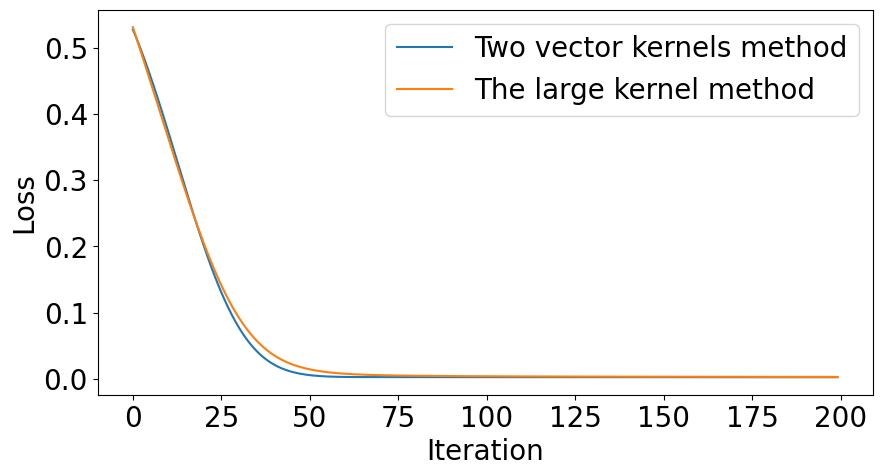

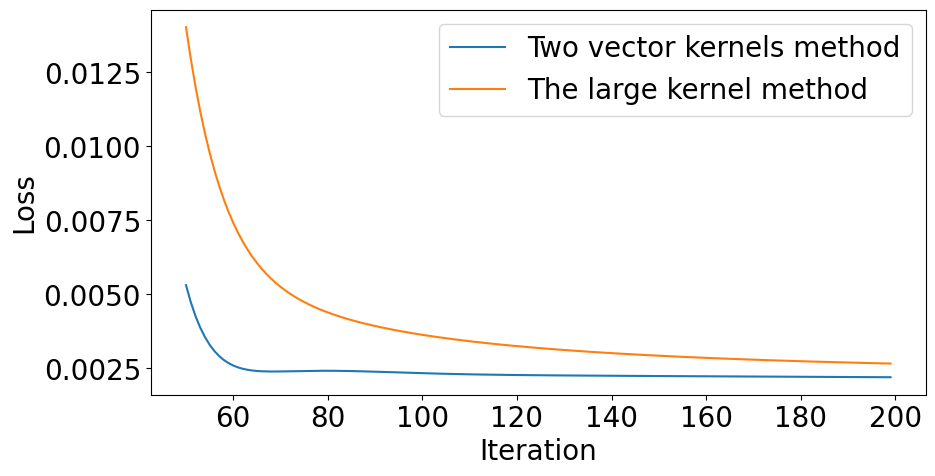

In [18]:
plt.rcParams['font.size'] = 20
# Loss changes in all the iterations
plt.figure(figsize=(10, 5))
plt.plot(losses_vector_kernel, label='Two vector kernels method')
plt.plot(losses_large_kernel, label='The large kernel method')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('all_Loss_changes_13.png', dpi=300)
plt.show()

# Loss changes in the last 150 iterations
iterations = np.arange(50, len(losses_vector_kernel))
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses_vector_kernel[50:], label='Two vector kernels method')
plt.plot(iterations, losses_large_kernel[50:], label='The large kernel method')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('last150_Loss_changes_13.png', dpi=300)
plt.show()

## Part02 : Compute the iteration threshold where the vector kernel method and the large kernel method spend the same time.

## 1. Set the desired experiment parameters.

In [11]:
# Constants
wavelength = 0.000000532
dx = 0.00000374
resolution = [1080, 1920]
distance = 0.55
learning_rate = 0.02
cuda = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Prepare for the intermedia variables and training the vector kernels.

In [12]:
large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase, kernel_height_phase,criterion,K_amplitude,K_phase,resolution_padded = prepare()
kernel_width_amplitude, kernel_height_amplitude, kernel_width_phase, kernel_height_phase=find_small_kernels(large_kernel, kernel_width_amplitude, kernel_height_amplitude,kernel_width_phase,kernel_height_phase, criterion, device, K_amplitude,K_phase,resolution_padded)

Training vector kernels: Iteration:149, Loss:0.0477: 100%|██████████| 150/150 [00:08<00:00, 17.58it/s]


## 3. Load a specific image to be processed to get its iteration threshold.

In [13]:
img_numpy = np.array(Image.open('./0013.png').resize((1920,1080)))
target=torch.from_numpy(np.mean(img_numpy,axis=2, dtype=np.float32))/255.0

## 4. Run the commands to compute the iteration threshold for the vector kernel method and the large kernel method.

In [14]:
iteration_list = range(85,115)

for iteration_number in iteration_list:
  loss_large = []
  loss_vector = []
  start_time_large = time.time()
  hologram, reconstructed,loss_large = stochastic_gradient_descent_losses(
      target,
      wavelength,
      distance,
      dx,
      resolution,
      None,
      n_iteration=iteration_number,
      learning_rate=learning_rate,
      cuda=True
  )
  end_time_large = time.time()


  # Optimize hologram
  start_time_vector = time.time()

  hologram_yes, reconstructed_yes, loss_vector = sgd_two_vector_kernels(
      target,
      wavelength,
      distance,
      dx,
      [1080,1920],
      1000,
      learning_rate,
      True,
      kernel_width_amplitude,
      kernel_height_amplitude,
      kernel_width_phase,
      kernel_height_phase,
      loss_large[-1]
  )
  end_time_vector = time.time()

  time_interval_large = end_time_large - start_time_large
  time_interval_vector = end_time_vector - start_time_vector
  ## Adjust the value in front of the time_interval_vector variable to compute the iteration threshold, 1.5 times faster and two times faster.
  if(time_interval_vector<time_interval_large):
    print(f"The large kernel method took {end_time_large - start_time_large} seconds to run {iteration_number}")
    print(f"The vector kernel method took {end_time_vector - start_time_vector} seconds to run {len(loss_vector)+1}")
    break


Iteration: 84 loss:0.0042


Hologram Optimization using vector kernels: Iteration: 53 loss:0.0039 Learning rate=0.02 Wavelength=5.32e-07 dx=3.74e-06 resolution=[1080, 1920]
The large kernel method took 4.619246959686279 seconds to run 85
The vector kernel method took 4.294995069503784 seconds to run 55


## Part02 : Reconstruction Quality.

## 1. Load the image.

In [19]:
img_numpy = np.array(Image.open('./0013.png').resize((1920,1080)))
target=torch.from_numpy(np.mean(img_numpy,axis=2, dtype=np.float32))/255.0

## 2. Run the commands to generate the reconstruction image in 100 iteration for the vector kernel method and the large kernel method.

In [20]:
hologram_large, reconstructed_large, loss_large = stochastic_gradient_descent_losses(
      target,
      wavelength,
      distance,
      dx,
      resolution,
      None,
      n_iteration=100,
      learning_rate=learning_rate,
      cuda=True
)

hologram_vector, reconstructed_vector, loss_vector = sgd_two_vector_kernels(
      target,
      wavelength,
      distance,
      dx,
      [1080,1920],
      1000,
      learning_rate,
      True,
      kernel_width_amplitude,
      kernel_height_amplitude,
      kernel_width_phase,
      kernel_height_phase,
      loss_large[-1]
)

Iteration: 99 loss:0.0037


Hologram Optimization using vector kernels: Iteration: 54 loss:0.0036 Learning rate=0.02 Wavelength=5.32e-07 dx=3.74e-06 resolution=[1080, 1920]


## 3. Save the image and compute its PSNR value with the target.

In [21]:
reconstructed_intensity_large = calculate_amplitude(reconstructed_large)**2
print('The PSNR value for the image reconstructed by the large kernel method is '+str(psnr(reconstructed_intensity_large.detach().to('cpu'),target.detach().to('cpu'))))
save_image('reconstructed_large_13.png',reconstructed_intensity_large,cmin=0.,cmax=1.)

reconstructed_intensity_vector = calculate_amplitude(reconstructed_vector)**2
print('The PSNR value for the image reconstructed by the vector kernel method is '+str(psnr(reconstructed_intensity_vector.detach().to('cpu'),target.detach().to('cpu'))))
save_image('reconstructed_vector_13.png',reconstructed_intensity_vector,cmin=0.,cmax=1.)

The PSNR value for the image reconstructed by the large kernel method is tensor(24.3990)
The PSNR value for the image reconstructed by the vector kernel method is tensor(24.4911)


True

## 4. Show the reconstructed image generated by the vector kernel and the large kernel method.

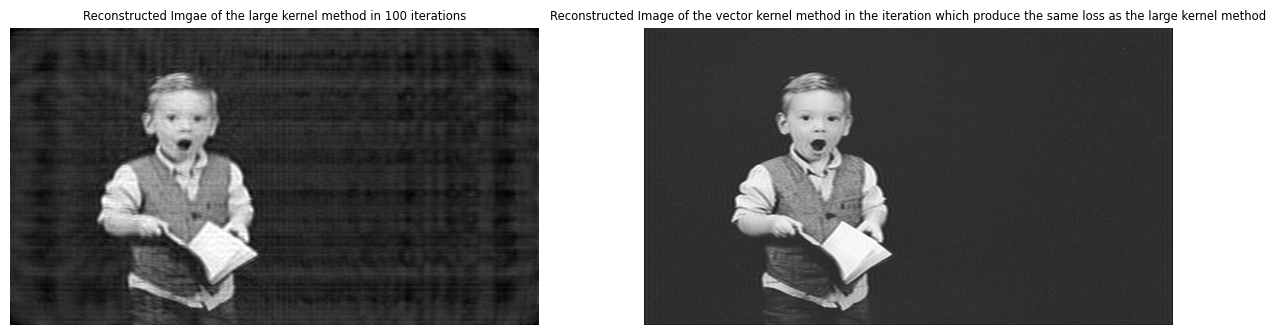

In [22]:
plt.rcParams['font.size'] = 7
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(reconstructed_intensity_large.detach().to('cpu'), cmap='gray',vmin=0.,vmax=1.)
ax[0].set_title('Reconstructed Imgae of the large kernel method in 100 iterations')
ax[0].axis('off')

ax[1].imshow(reconstructed_intensity_vector.detach().to('cpu'), cmap='gray', vmin=0.,vmax=1.)
ax[1].set_title('Reconstructed Image of the vector kernel method in the iteration which produce the same loss as the large kernel method')
ax[1].axis('off')

plt.show()